---

### Goals

Define lists of RBPs (based on external publications and our model output)

### Changelog

- 20250107 forked from
    - `notebooks/manuscripts/biology-rbps-in-activation/KR20241114.mapping_reference_list_identifiers.ipynb`
    - `notebooks/manuscripts/biology-rbps-in-activation/KR20241119.4_validation_oops_rbps.ipynb`

---

In [1]:
%cd ../../../../

/home/k.rooijers/Projects/OOPS_2023


/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


---

In [2]:
import numpy as np
import pandas as pd

In [3]:
import duckdb

import blitzgsea

In [4]:
from matplotlib import pyplot as plt

In [5]:
import xarray

In [6]:
np.random.seed(42)

---

### Data loading

In [7]:
sample_subset = pd.read_csv("pipeline_activation/samplesheet.tsv", sep="\t")

In [8]:
intensities = pd.read_csv(
    "pipeline_activation/intensity-values.tsv",
    sep="\t", index_col=0,
)

Raw numbers for manuscript maintext:

In [9]:
intensities.shape

(7531, 30)

In [10]:
(~(np.isclose(
    intensities[sample_subset.groupby(['library_type']).get_group(("OOPS", ))["sample_label"]].values,
    0.,
).all(axis=1))).sum()

4922

In [11]:
(~(np.isclose(
    intensities[sample_subset.groupby(['library_type']).get_group(("fullproteome", ))["sample_label"]].values,
    0.,
).all(axis=1))).sum()

6922

In [12]:
w_valid = intensities['w_valid']

In [13]:
w_valid.sum()

5561

In [14]:
hgnc_metadata = pd.read_csv(
    "pipeline_activation/raw/hgnc_metadata.tsv.gz",
    sep="\t", index_col=0,
)

Load Uniprot -> HGNC mapping

In [15]:
DBFN = "data/vendor/KR20231013.human_omni_gene.db"

dbconn = duckdb.connect(DBFN, read_only=True)

In [16]:
# uniprot2hgncid = (
#     dbconn.execute("SELECT primary_accession, hgnc_refs FROM uniprot")
#     .df()
#     .assign(**{'hgnc_refs': lambda df: df['hgnc_refs'].apply(set)})
#     .set_index("primary_accession", verify_integrity=True)
#     .iloc[:, 0]
#     .to_dict()
# )

uniprot2hgncid = (
    dbconn.execute("SELECT primary_accession, hgnc_refs[1] FROM uniprot WHERE length(hgnc_refs) == 1")
    .df()
    .set_index("primary_accession", verify_integrity=True)
    .iloc[:, 0]
    .to_dict()
)

Load vendored data:

In [17]:
Queiroz_NatBio_2019_tbl = pd.read_excel(
    "./data/vendor/41587_2018_1_MOESM4_ESM.xlsx",
    sheet_name=0, skiprows=1, nrows=1839,
)

Queiroz_NatBio_2019_tbl.head()

,Uniprot_ID,HEK293,MCF10A,U2OS,GO_RBP,RBP_Capture
0,A0AVT1,1,0,1,False,False
1,A1L390,0,0,1,False,False
2,A1X283,0,1,0,False,False
3,A2RRP1,1,0,1,False,False
4,A4D1P6,1,0,0,False,False


In [18]:
Queiroz_NatBio_2019_tbl["Uniprot_ID"].map(uniprot2hgncid).isna().sum()

5

In [19]:
PerezPerri_NatComm_2018_tbl = pd.read_excel(
    "./data/vendor/41467_2018_6557_MOESM3_ESM.xlsx",
    sheet_name=1,
)

PerezPerri_NatComm_2018_tbl.head()

,gene_name,protein_id,description,qupm,log2-FC,p-value,FDR,hit annotation
0,DDX17,H3BLZ8|Q92841,Probable ATP-dependent RNA helicase DDX17 OS=H...,22,5.514422,7.548206e-08,0.000009,hit
1,FMR1,Q06787|Q06787-3|Q06787-5|Q06787-8|Q06787-9,Synaptic functional regulator FMR1 OS=Homo sap...,9,5.482367,1.004970e-07,0.000009,hit
2,HNRNPR,O43390|O43390-2,Heterogeneous nuclear ribonucleoprotein R OS=H...,26,5.786582,1.036787e-07,0.000009,hit
3,HNRNPH1,D6RAM1|G8JLB6|P31943,Heterogeneous nuclear ribonucleoprotein H (Fra...,12,5.762610,1.109332e-07,0.000009,hit
4,HNRNPD,Q14103-3|Q14103-4,Isoform 3 of Heterogeneous nuclear ribonucleop...,14,5.707825,1.435938e-07,0.000009,hit


In [20]:
(
    PerezPerri_NatComm_2018_tbl['protein_id']
    .str.split("|")
    .map(
        lambda l: sorted(set(
            filter(None, map(uniprot2hgncid.get, l))
        ))
    )
)

0       [HGNC:2740]
1       [HGNC:3775]
2       [HGNC:5047]
3       [HGNC:5041]
4                []
           ...     
702     [HGNC:4983]
703     [HGNC:5000]
704     [HGNC:4718]
705     [HGNC:4838]
706    [HGNC:10448]
Name: protein_id, Length: 707, dtype: object

Via symbol? (isn't better, outdated HGNC symbols...)

In [21]:
data_symbol2hgncid = hgnc_metadata['symbols'].str.split(";").explode().reset_index().set_index('symbols').squeeze().to_dict()

In [22]:
PerezPerri_NatComm_2018_tbl['gene_name'].map(data_symbol2hgncid)

0                HGNC:2740;HGNC:2746;HGNC:18684
1                           HGNC:3775;HGNC:4024
2                          HGNC:5047;HGNC:16918
3                 HGNC:5041;HGNC:5042;HGNC:5043
4                           HGNC:5036;HGNC:5037
                         ...                   
702    HGNC:4983;HGNC:5000;HGNC:5004;HGNC:18653
703                                   HGNC:5000
704                                         NaN
705                                         NaN
706                        HGNC:9162;HGNC:10448
Name: gene_name, Length: 707, dtype: object

In [23]:
PerezPerri_NatComm_2018_tbl['gene_name']

0         DDX17
1          FMR1
2        HNRNPR
3       HNRNPH1
4        HNRNPD
         ...   
702       HMGB1
703       HMGB2
704    HIST1H1E
705    SERPIND1
706       RRBP1
Name: gene_name, Length: 707, dtype: object

NB: e.g. `HIST1H1E` is now `H1-4`

Load "Vigo table" (Hoefig et al. https://pmc.ncbi.nlm.nih.gov/articles/PMC8410761/)

In [24]:
hoefig_tbl = pd.read_excel("data/vendor/41467_2021_25345_MOESM4_ESM.xlsx", sheet_name="Human OOPS Th0")

In [25]:
hoefig_tbl.head()

,LFQ intensity CL_RNase_organic_1,LFQ intensity CL_RNase_organic_2,LFQ intensity CL_RNase_organic_3,LFQ intensity CL_RNase_organic_4,LFQ intensity nCL_RNase_organic_1,LFQ intensity nCL_RNase_organic_2,LFQ intensity nCL_RNase_organic_3,LFQ intensity nCL_RNase_organic_4,Gene names,T-test Significant,-Log Student's T-test p-value CL_R_org_NL_R_org,Student's T-test q-value CL_R_org_NL_R_org,Student's T-test Difference CL_R_org_NL_R_org,Student's T-test Test statistic CL_R_org_NL_R_org,Majority protein IDs,Protein names
0,35.5659,35.2205,35.1510,35.5707,25.8290,25.4421,25.4232,24.2799,YBX1,+,6.92985,0.0,10.13350,7.49188,P67809,Nuclease-sensitive element-binding protein 1
1,35.0448,34.8249,35.2675,35.2487,24.9502,25.8854,25.4474,25.9579,RPS15,+,7.61711,0.0,9.53624,7.60128,P62841,40S ribosomal protein S15
2,34.6936,34.2767,34.8210,34.7033,25.3245,25.9221,23.8480,25.9712,RBMX,+,5.77587,0.0,9.35722,6.19974,P38159,"RNA-binding motif protein, X chromosome;RNA-bi..."
3,33.4600,33.7811,33.5923,33.7026,27.2141,24.9902,24.8177,26.0107,LARP1,+,5.10940,0.0,7.87584,5.06001,Q6PKG0,La-related protein 1
4,33.6652,33.6615,33.5697,33.7067,25.8560,26.0788,25.6806,25.7779,RPL29,+,9.81157,0.0,7.80247,7.16095,P47914,60S ribosomal protein L29


In [26]:
hoefig_tbl.columns

Index(['LFQ intensity CL_RNase_organic_1', 'LFQ intensity CL_RNase_organic_2',
       'LFQ intensity CL_RNase_organic_3', 'LFQ intensity CL_RNase_organic_4',
       'LFQ intensity nCL_RNase_organic_1',
       'LFQ intensity nCL_RNase_organic_2',
       'LFQ intensity nCL_RNase_organic_3',
       'LFQ intensity nCL_RNase_organic_4', 'Gene names', 'T-test Significant',
       '-Log Student's T-test p-value CL_R_org_NL_R_org',
       'Student's T-test q-value CL_R_org_NL_R_org',
       'Student's T-test Difference CL_R_org_NL_R_org',
       'Student's T-test Test statistic CL_R_org_NL_R_org',
       'Majority protein IDs', 'Protein names'],
      dtype='object')

In [27]:
hoefig_rbp_genes = set(hoefig_tbl[
    hoefig_tbl['T-test Significant'].fillna("").str.contains("+", regex=False)
]["Gene names"].fillna(""))

In [28]:
assert len(hoefig_rbp_genes) == 1159  # see main text

In [29]:
hoefig_rbp_symbols = set(
    sym
    for s in hoefig_rbp_genes
    for sym in s.split(";")
)

In [30]:
len(hoefig_rbp_symbols)

1176

---

#### Define tables listing whether our HGNC IDs are included in external RBP datasets:

In [31]:
Queiroz_NatBio_2019_hgncids = {
    col: set(
        Queiroz_NatBio_2019_tbl[
            (Queiroz_NatBio_2019_tbl[col] == 1)
        ][
            "Uniprot_ID"
        ]
        .map(uniprot2hgncid)
        .dropna()
        .values
    )
    for col in Queiroz_NatBio_2019_tbl.columns[1:4]
}

{col: len(Queiroz_NatBio_2019_hgncids[col]) for col in Queiroz_NatBio_2019_hgncids}

{'HEK293': 1406, 'MCF10A': 1162, 'U2OS': 1264}

In [32]:
PerezPerri_NatComm_2018_hgncids = set((
    PerezPerri_NatComm_2018_tbl[
        (PerezPerri_NatComm_2018_tbl["hit annotation"] == "hit")
    ]
    ['protein_id']
    .str.split("|")
    .map(
        lambda l: sorted(set(
            filter(None, map(uniprot2hgncid.get, l))
        ))
    )
    .explode()
    .dropna()
    .values
))

len(PerezPerri_NatComm_2018_hgncids)

681

In [33]:
Queiroz_NatBio_2019_datadf = pd.DataFrame({
    col: (
        hgnc_metadata.index.str.split(";").map(
            lambda l: any(
                s in Queiroz_NatBio_2019_hgncids[col] for s in l
            )
    ))
    for col in Queiroz_NatBio_2019_tbl.columns[1:4]
})

In [34]:
Queiroz_NatBio_2019_datadf.sum()

HEK293    1897
MCF10A    1625
U2OS      1675
dtype: int64

In [35]:
PerezPerri_NatComm_2018_datadf = pd.DataFrame({
    "hit": hgnc_metadata.index.str.split(";").map(
        lambda l: any(s in PerezPerri_NatComm_2018_hgncids for s in l)
    )
})

In [36]:
PerezPerri_NatComm_2018_datadf.sum()

hit    944
dtype: int64

In [37]:
Hoefig_NatComm_2021_datadf = pd.DataFrame({
    "hit": hgnc_metadata['symbols'].str.split(";").map(set).apply(
        lambda s: any(s & hoefig_rbp_symbols)
    )
})

In [38]:
inclusion_datadf = pd.concat([
    (
        Queiroz_NatBio_2019_datadf
        .set_index(hgnc_metadata.index)
        .rename(lambda l: "queiroz_" + l, axis=1)
    ),
    (
        PerezPerri_NatComm_2018_datadf
        .set_index(hgnc_metadata.index)
        .rename(lambda l: "perezperri_" + l, axis=1)
    ),
    (
        Hoefig_NatComm_2021_datadf
        .set_index(hgnc_metadata.index)
        .rename(lambda l: "hoefig_" + l, axis=1)
    ),
], axis=1)

inclusion_datadf.sum()

queiroz_HEK293    1897
queiroz_MCF10A    1625
queiroz_U2OS      1675
perezperri_hit     944
hoefig_hit        1519
dtype: int64

In [39]:
assert len(inclusion_datadf) == len(intensities)

assert (inclusion_datadf.index == intensities.index).all()

assert (inclusion_datadf.index == hgnc_metadata.index).all()

---

#### Define RBPs based on OOPS:CL coefficient

Define Strong and Weak set based on per-gene HDIs (model output)

Load gene sets from MSigDB:

In [40]:
gs_library = {
    k: list(set(v))
    for (k, v) in dbconn.execute("""
SELECT gs.standard_name, s.symbol
FROM msigdb_gene_set as gs
INNER JOIN msigdb_gene_set_gene_symbol as gsgs ON gsgs.gene_set_id = gs.id
INNER JOIN msigdb_gene_symbol as s ON gsgs.gene_symbol_id = s.id
WHERE gs.collection_name = 'C5:GO:MF'
""").df().groupby("standard_name")['symbol']
    if len(v) >= 5
}

Use MAP:

In [41]:
map_ds = xarray.load_dataset("pipeline_activation/model-output/global_map.h5")

Define "Signature" dataframe for blitzgsea:

In [42]:
len(hgnc_metadata)

7531

In [43]:
E = xarray.concat(
    [map_ds['E'], map_ds['Ederiv'].rename({"deriv_coef": "coef"})],
    dim='coef',
)

In [44]:
len(hgnc_metadata.loc[E.coords['gene'].values])

5561

In [45]:
import seaborn

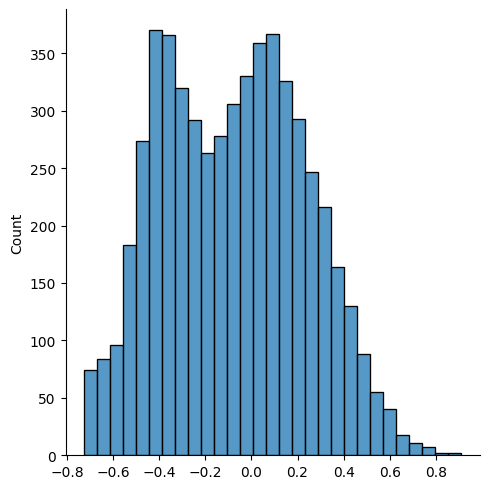

In [46]:
seaborn.displot(E.sel(coef='Intercept'))

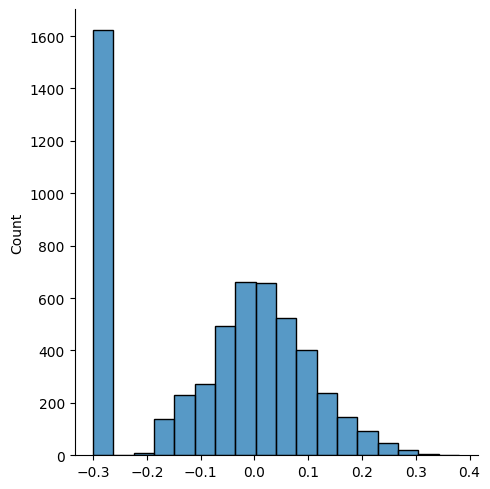

In [47]:
seaborn.displot(E.sel(coef='OOPS_abundance'))

In [48]:
w_expr = (
    (E.sel(coef='Intercept') >= -0.75)
    & (E.sel(coef='OOPS_abundance') >= -0.25)
)
assert w_expr.mean().item() >= 0.6

w_expr.mean().item(), w_expr.sum().item()

(0.7083258406761374, 3939)

In [49]:
gene_symbols = hgnc_metadata.loc[E.coords['gene'].values]['symbols'].values

In [50]:
assert len(gene_symbols) == w_valid.sum()

In [51]:
signature_df = pd.DataFrame(
    {
        0: gene_symbols,
        1: E.sel(coef='RBPness'),
    },
)[w_expr.values]

signature_df.head()

,0,1
1,RING1,-0.022106
2,RIPK1,0.009333
3,RIPK3,-0.035198
4,TRIM38,0.005294
7,RNF20,0.005065


Run blitzgsea:

In [52]:
result = blitzgsea.gsea(
    signature_df, gs_library,
    processes=4, progress=True, verbose=True,
    signature_cache=False,
    permutations=10_000, seed=42,
    add_noise=True,
    symmetric=False, anchors=50,
    kl_bins=200,
)

result.head()

Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1772/1772 [00:00<00:00, 8525.53it/s]

Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.005669840647620523
KS p-value (neg): 0.04217743918040813



/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


,es,nes,pval,sidak,fdr,geneset_size,leading_edge
Term,,,,,,,
GOMF_RNA_BINDING,0.341611,5.616244,1.951534e-08,0.000015,0.000015,1095,"ZCCHC3,PUM1,YBX3,MRPL2,LSM8,RBM7,DHX8,RBMXL1,H..."
GOMF_MRNA_BINDING,0.455980,4.794000,1.634882e-06,0.001240,0.000620,199,"HNRNPM,PUM1,YBX3,LSM14B,EIF2A,SYNCRIP,TIAL1,RB..."
GOMF_MRNA_3_UTR_BINDING,0.628517,4.200233,2.666399e-05,0.020035,0.006746,57,"PUM1,YBX3,TIAL1,KHSRP,DHX36,RSL1D1,ILF3,ZFP36L..."
GOMF_CATALYTIC_ACTIVITY_ACTING_ON_RNA,0.394664,3.679818,2.334003e-04,0.162364,0.044288,199,"DDX21,DHX8,PUS1,FBL,CNOT1,DHX36,EXOSC1,PRORP,D..."
GOMF_STRUCTURAL_CONSTITUENT_OF_RIBOSOME,0.435782,3.468468,5.234345e-04,0.327929,0.079457,121,"MRPL2,MRPL30,RPL36AL,MRPL15,RPL6,MRPL3,MRPL44,..."


Reorder results:

In [53]:
(
    result
    .assign(**{"abs_nes": lambda df: np.abs(df['nes'])})
    .loc[lambda df: df['pval'] < 1e-2]
    .loc[lambda df: df['geneset_size'] > 25]
    .sort_values("abs_nes", ascending=False)
).head(20)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,abs_nes
Term,,,,,,,,
GOMF_RNA_BINDING,0.341611,5.616244,1.951534e-08,0.000015,0.000015,1095,"ZCCHC3,PUM1,YBX3,MRPL2,LSM8,RBM7,DHX8,RBMXL1,H...",5.616244
GOMF_MRNA_BINDING,0.455980,4.794000,1.634882e-06,0.001240,0.000620,199,"HNRNPM,PUM1,YBX3,LSM14B,EIF2A,SYNCRIP,TIAL1,RB...",4.794000
GOMF_MRNA_3_UTR_BINDING,0.628517,4.200233,2.666399e-05,0.020035,0.006746,57,"PUM1,YBX3,TIAL1,KHSRP,DHX36,RSL1D1,ILF3,ZFP36L...",4.200233
GOMF_CATALYTIC_ACTIVITY_ACTING_ON_RNA,0.394664,3.679818,2.334003e-04,0.162364,0.044288,199,"DDX21,DHX8,PUS1,FBL,CNOT1,DHX36,EXOSC1,PRORP,D...",3.679818
GOMF_STRUCTURAL_CONSTITUENT_OF_RIBOSOME,0.435782,3.468468,5.234345e-04,0.327929,0.079457,121,"MRPL2,MRPL30,RPL36AL,MRPL15,RPL6,MRPL3,MRPL44,...",3.468468
GOMF_ATP_DEPENDENT_ACTIVITY_ACTING_ON_RNA,0.533262,3.206759,1.342392e-03,0.639246,0.169813,55,"DHX33,DDX59,DDX50,DDX21,DDX3Y,DHX8,DDX46,DDX31...",3.206759
GOMF_ORGANIC_ANION_TRANSMEMBRANE_TRANSPORTER_ACTIVITY,0.621906,3.127226,1.764642e-03,0.738297,0.172212,34,"ABCC4,ABCB1,SLC1A3,SLC39A14,ABCC5,SLC26A2,SLC1...",3.127226
GOMF_RRNA_BINDING,0.541488,3.096182,1.960303e-03,0.774476,0.172212,49,"RPS11,KDM2B,FASTKD2,MRPS17,CIRBP,NOP53,RPL5,RR...",3.096182
GOMF_SALT_TRANSMEMBRANE_TRANSPORTER_ACTIVITY,0.537227,3.084049,2.042036e-03,0.788068,0.172212,50,"ATP2B4,P2RX4,SLC12A6,SLC25A1,ATP1A1,ITPR2,SLC1...",3.084049


Export table:
    
**TODO**

In [54]:
# use RNA binding GO term:
gs_name = 'GOMF_RNA_BINDING'
# gs_name = 'GOMF_MRNA_BINDING'
# gs_name = 'GOMF_MRNA_3_UTR_BINDING'

result.loc[gs_name]

es                                                       0.341611
nes                                                      5.616244
pval                                                          0.0
sidak                                                    0.000015
fdr                                                      0.000015
geneset_size                                                 1095
leading_edge    ZCCHC3,PUM1,YBX3,MRPL2,LSM8,RBM7,DHX8,RBMXL1,H...
Name: GOMF_RNA_BINDING, dtype: object

Define `apex` set of genes ("leading edge" in GSEA terminology):

In [55]:
gs = set(gs_library[gs_name])

in_gs = np.array(
    list(map(any, map(lambda s: s & gs, map(set, map(lambda s: s.split(";"), gene_symbols.tolist())))))
)

in_gs.shape

(5561,)

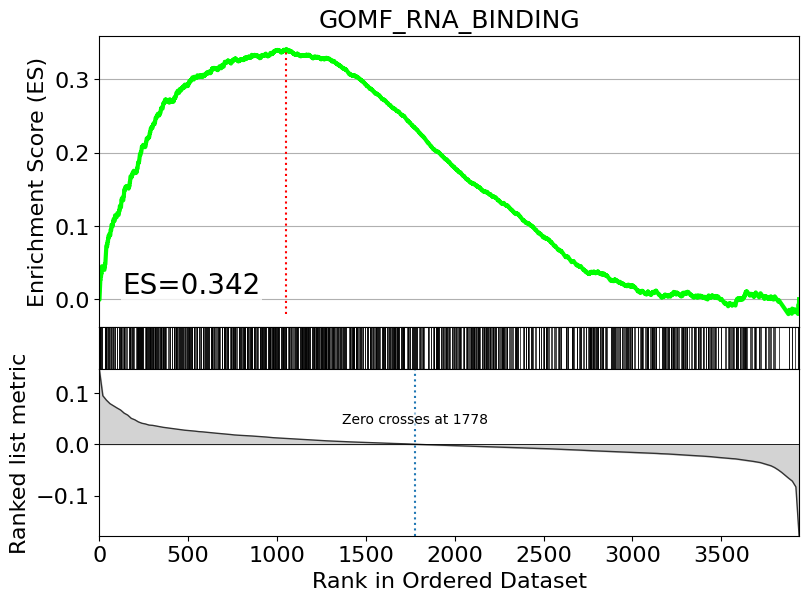

In [56]:
blitzgsea.plot.running_sum(signature_df, gs_name, gs_library)

*Butcher the code from `blitzgsea.plot.running_sum` to get the running sum and determine the (position of) the score of the leading edge, to define "high-confidence RBPs"..*

In [57]:
signature = signature_df.copy()
signature.columns = ["i", "v"]
signature = signature.sort_values("v", ascending=False).set_index("i")
signature = signature[~signature.index.duplicated(keep='first')]
signature.loc[:, "v"] -= np.mean(signature.loc[:, "v"])
signature_map = {}
for i, h in enumerate(signature.index):
    signature_map[h] = i

In [58]:
hits = [i for i, x in enumerate(signature.index) if x in set(gs_library[gs_name])]

running_sum, es = blitzgsea.enrichment_score(np.array(np.abs(signature.iloc[:, 0])), signature_map, gs)
running_sum = list(running_sum)

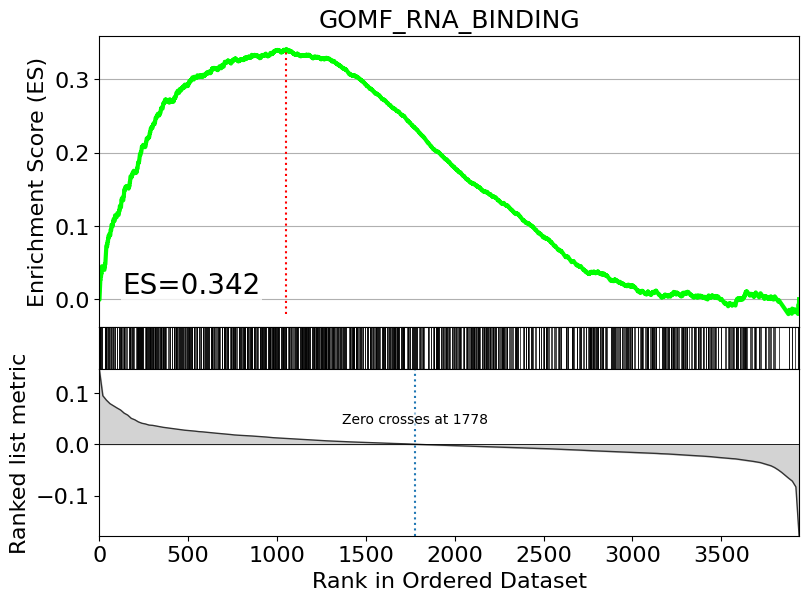

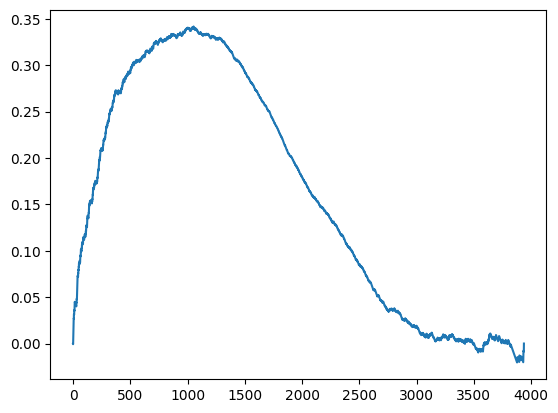

In [59]:
fig, ax = plt.subplots(1, 1)

ax.plot(running_sum)

In [60]:
np.array(running_sum).argmax()

1053

In [61]:
signature.iloc[0:np.array(running_sum).argmax()].index.values

array(['H2AX', 'LIPE', 'ZCCHC3', ..., 'ACAT1', 'PABPC1', 'PPAN'],
      dtype=object)

For overlap we need to define a set of RBPs from our data. "Calling RBPs" is done by:

- using the apex of running sum of GSEA for RBPness (median of 40% HDI) for gene set `GOMF_RNA_BINDING`
- using the lower 90% HDI for RBPness

In [62]:
assert len(running_sum) == w_expr.sum()

In [63]:
assert (np.sort(signature['v'])[::-1] == signature['v']).all()

In [64]:
np.argmax(running_sum)

1053

In [65]:
symbols2hgncids = hgnc_metadata['symbols'].reset_index().set_index('symbols').squeeze().to_dict()

In [66]:
apex_set = set(map(symbols2hgncids.get, signature.iloc[0:np.argmax(running_sum)].index))

In [67]:
hdi_ds = xarray.load_dataset("pipeline_activation/model-output/pergene_hdis.h5")

In [68]:
ROPE_CUTOFF = -0.01

[]

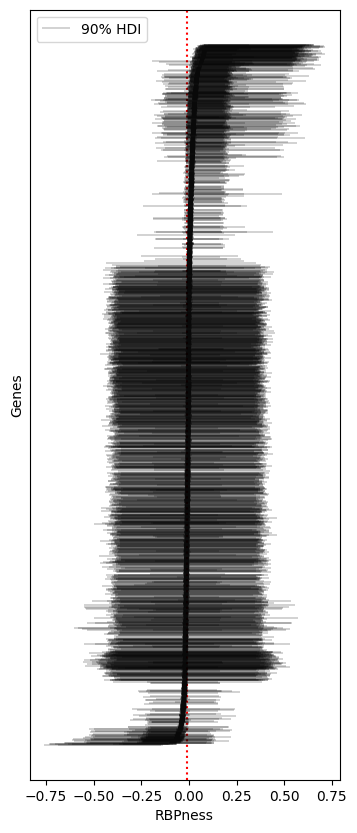

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
# o = hdi_ds['Hd40'].sel(deriv_coef='RBPness').median(dim='hdi').argsort().values
o = E.sel(coef='RBPness').argsort().values
ax.hlines(
    y=np.arange(o.size),
    xmin=hdi_ds['Hd90'].sel(deriv_coef='RBPness').sel(hdi='lower').values[o],
    xmax=hdi_ds['Hd90'].sel(deriv_coef='RBPness').sel(hdi='higher').values[o],
    ls="-", color="black", lw=0.25, alpha=1, zorder=10,
    label="90% HDI",
)

ax.axvline(ROPE_CUTOFF, color='red', zorder=2, ls=":")
ax.legend(loc="upper left")
ax.set_xlabel('RBPness')
ax.set_ylabel("Genes")
ax.set_yticks([])

In [70]:
E.coords['coef']

<xarray.DataArray 'coef' (coef: 15)> Size: 2kB
array(['Intercept', 'libtype[S.OOPS]', 'act[S.no]', 'cl[S.no]',
       'libtype[S.OOPS]:act[S.no]', 'libtype[S.OOPS]:cl[S.no]',
       'act[S.no]:cl[S.no]', 'libtype[S.OOPS]:act[S.no]:cl[S.no]',
       'OOPS_abundance', 'activation', 'activation_FP', 'RBPness',
       'lt_deltaRBPness', 'act_deltaRBPness', 'act_deltaCL'], dtype='<U34')
Coordinates:
  * coef     (coef) <U34 2kB 'Intercept' 'libtype[S.OOPS]' ... 'act_deltaCL'

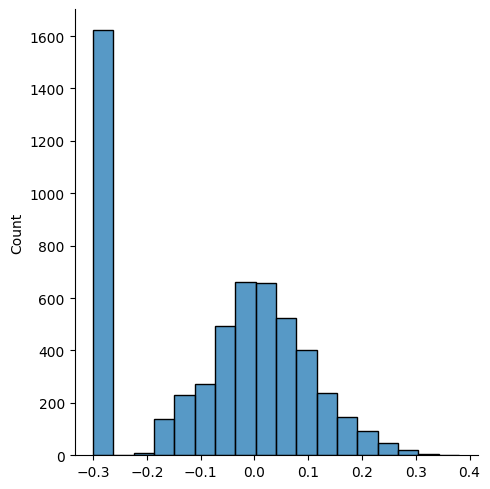

In [71]:
seaborn.displot(E.sel(coef='OOPS_abundance'))

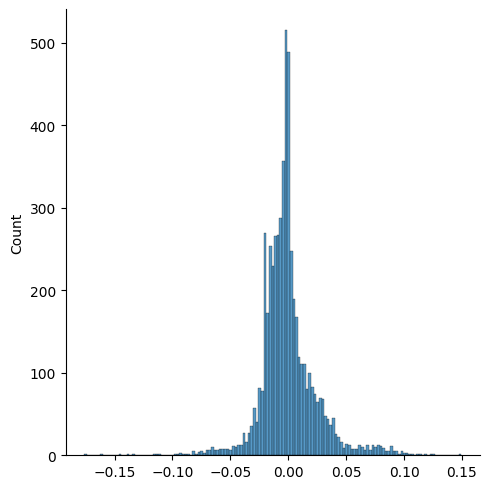

In [72]:
seaborn.displot(E.sel(coef='RBPness'))

In [73]:
rope_set = set(hdi_ds['gene'][
    (hdi_ds['Hd90'].sel(deriv_coef='RBPness').sel(hdi='lower') >= ROPE_CUTOFF)
    & (E.sel(coef='OOPS_abundance') >= -0.2)
].values)

In [74]:
strong_set = apex_set | rope_set

In [75]:
len(apex_set), len(rope_set), len(apex_set & rope_set), len(strong_set)

(1053, 1361, 800, 1614)

In [76]:
len(strong_set) / w_valid.sum()

0.2902355691422406

In [77]:
weakbinder_set = set(E.coords['gene'][
    (E.sel(coef='RBPness') >= 0.01)
#     hdi_ds['Hd90'].sel(deriv_coef='RBPness').median(dim='hdi') > 0
].values)

In [78]:
# weakbinder_set -= strong_set

In [79]:
extension_set = weakbinder_set - strong_set

In [80]:
len(weakbinder_set), len(weakbinder_set - apex_set), len(weakbinder_set & rope_set), len(extension_set)

(1244, 191, 955, 36)

In [81]:
weak_set = extension_set | strong_set

In [82]:
len(weak_set)

1650

In [83]:
gs_symbol_set = set(gs_library[gs_name])

In [84]:
rbp_definition_table = pd.DataFrame({
    "strong_set": pd.Series(hgnc_metadata.index.isin(strong_set), index=hgnc_metadata.index),
    "weak_set": pd.Series(hgnc_metadata.index.isin(weak_set), index=hgnc_metadata.index),
    "apex_set": pd.Series(hgnc_metadata.index.isin(apex_set), index=hgnc_metadata.index),
    "rope_set": pd.Series(hgnc_metadata.index.isin(rope_set), index=hgnc_metadata.index),
    "goterm_set": hgnc_metadata['symbols'].str.split(";").apply(lambda l: any(set(l) & gs_symbol_set)),
})

In [85]:
assert (rbp_definition_table.index == intensities.index).all()

assert (rbp_definition_table.index == hgnc_metadata.index).all()

---

#### Define "detected" genes in full proteome and OOPS samples (any detection in any `library_type`-grouped sample)

In [86]:
sample_subset.groupby(['library_type']).size()

library_type
OOPS            12
fullproteome    12
dtype: int64

In [87]:
any_detection = pd.DataFrame({
    k: (intensities[v] > 0).any(axis=1)
    for (k, v) in (
        sample_subset
        .groupby(['library_type'])
        .pipe(lambda df: df['sample_label'])
        .agg(list)
        .to_dict().items()
    )
})

In [88]:
assert (any_detection.index == intensities.index).all()

assert (any_detection.index == hgnc_metadata.index).all()

---

#### Export table 

In [89]:
output_tbl = pd.concat([
    inclusion_datadf,
    rbp_definition_table,
    any_detection,
    intensities[["w_valid"]],
    pd.DataFrame({"w_expr": w_expr}, index=hgnc_metadata.index[w_valid]).reindex(hgnc_metadata.index).fillna(False),
], axis=1)

/tmp/ipykernel_375221/4262880879.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pd.DataFrame({"w_expr": w_expr}, index=hgnc_metadata.index[w_valid]).reindex(hgnc_metadata.index).fillna(False),


In [90]:
output_tbl.sum()

queiroz_HEK293    1897
queiroz_MCF10A    1625
queiroz_U2OS      1675
perezperri_hit     944
hoefig_hit        1519
strong_set        1614
weak_set          1650
apex_set          1053
rope_set          1361
goterm_set        1715
OOPS              4922
fullproteome      6922
w_valid           5561
w_expr            3939
dtype: int64

In [91]:
output_tbl.to_csv(
    "pipeline_activation/genelists.tsv",
    sep="\t",
)

---

#### Generate plots with overlap

In [92]:
output_tbl['goterm_set'].sum()

1715

In [93]:
(output_tbl['goterm_set'] & output_tbl['fullproteome']).sum()

1641

In [94]:
(output_tbl['goterm_set'] & output_tbl['fullproteome'] & output_tbl['w_valid']).sum()

1211

In [95]:
(output_tbl['goterm_set'] & output_tbl['OOPS'] & output_tbl['w_valid']).sum()

1097

In [96]:
(output_tbl['goterm_set'] & output_tbl['strong_set'] & output_tbl['w_valid']).sum()

## equal to:
# (output_tbl['goterm_set'] & output_tbl['strong_set']).sum()

583

In [97]:
(output_tbl['goterm_set'] & output_tbl['queiroz_U2OS']).sum()

913

In [98]:
(output_tbl['goterm_set'] & output_tbl['weak_set'] & output_tbl['w_valid']).sum()

## equal to:
# (output_tbl['goterm_set'] & output_tbl['weak_set']).sum()

587

In [99]:
(output_tbl['goterm_set'] & output_tbl['perezperri_hit']).sum()

845

<BarContainer object of 1 artists>

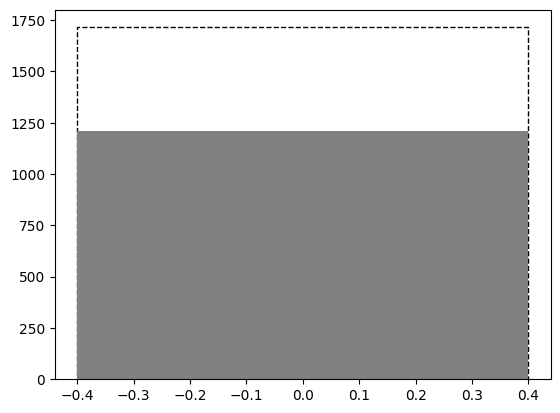

In [100]:
fig, ax = plt.subplots(1, 1)

ax.bar(
    [0.],
    [output_tbl['goterm_set'].sum()],
    color='none', edgecolor='black', ls="--", lw=1.,
)

ax.bar(
    [0.],
    [(output_tbl['goterm_set'] & output_tbl['fullproteome'] & output_tbl['w_valid']).sum()],
    color='grey', edgecolor='none',
)

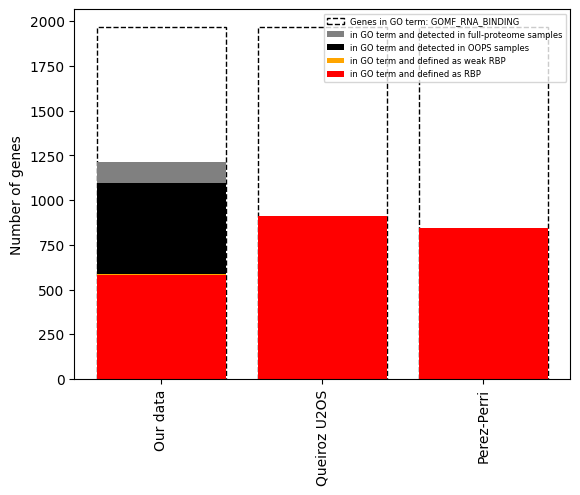

In [101]:
fig, ax = plt.subplots(1, 1)

ax.bar(
    [0.],
#     [output_tbl['goterm_set'].sum()],
    [len(gs_library[gs_name])],
    color='none', edgecolor='black', ls="--", lw=1.,
    label="Genes in GO term: %s" % gs_name,
)

ax.bar(
    [0.],
    [(output_tbl['goterm_set'] & output_tbl['fullproteome'] & output_tbl['w_valid']).sum()],
    color='grey', edgecolor='none',
    label="in GO term and detected in full-proteome samples",
)

ax.bar(
    [0.],
    [(output_tbl['goterm_set'] & output_tbl['OOPS'] & output_tbl['w_valid']).sum()],
    color='black', edgecolor='none',
    label="in GO term and detected in OOPS samples",
)

ax.bar(
    [0.],
    [(output_tbl['goterm_set'] & output_tbl['weak_set'] & output_tbl['w_valid']).sum()],
    color='orange', edgecolor='none',
    label="in GO term and defined as weak RBP",
)

ax.bar(
    [0.],
    [(output_tbl['goterm_set'] & output_tbl['strong_set'] & output_tbl['w_valid']).sum()],
    color='red', edgecolor='none',
    label="in GO term and defined as RBP",
)

###

ax.bar(
    [1.],
    [len(gs_library[gs_name])],
    color='none', edgecolor='black', ls="--", lw=1.,
)

ax.bar(
    [1.],
    [(output_tbl['goterm_set'] & output_tbl['queiroz_U2OS']).sum()],
    color='red', edgecolor='none',
)

###

ax.bar(
    [2.],
    [len(gs_library[gs_name])],
    color='none', edgecolor='black', ls="--", lw=1.,
)

ax.bar(
    [2.],
    [(output_tbl['goterm_set'] & output_tbl['perezperri_hit']).sum()],
    color='red', edgecolor='none',
)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Our data", "Queiroz U2OS", "Perez-Perri"], rotation=90)
ax.set_ylabel("Number of genes")
ax.legend(prop=dict(size=6))

fig.savefig("pipeline_activation/figures/rbp-overlap.pdf", format='pdf')

Make Venn diagram and write to file

In [102]:
import matplotlib_venn

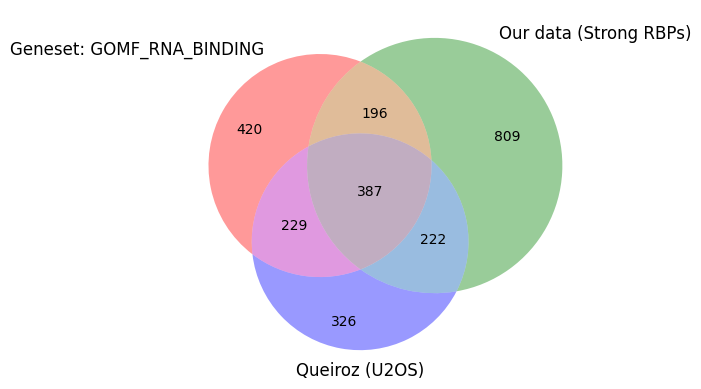

In [103]:
matplotlib_venn.venn3(
    (
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['goterm_set']
            )
        ].index),
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['strong_set']
            )
        ].index),
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['queiroz_U2OS']
            )
        ].index),
    ),
    set_labels=['Geneset: %s' % gs_name, "Our data (Strong RBPs)", "Queiroz (U2OS)"]
)

fig = plt.gcf()
fig.savefig("pipeline_activation/figures/venn_RBP_overlap.geneset_%s-Queiroz-ours.pdf" % gs_name);

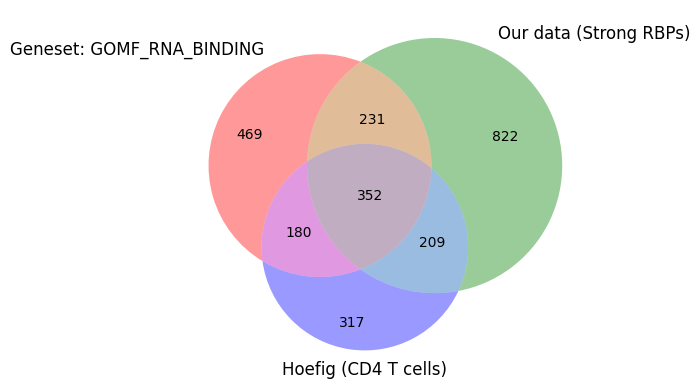

In [104]:
matplotlib_venn.venn3(
    (
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['goterm_set']
            )
        ].index),
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['strong_set']
            )
        ].index),
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['hoefig_hit']
            )
        ].index),
    ),
    set_labels=['Geneset: %s' % gs_name, "Our data (Strong RBPs)", "Hoefig (CD4 T cells)"]
)

fig = plt.gcf()
fig.savefig("pipeline_activation/figures/venn_RBP_overlap.geneset_%s-Hoefig-ours.pdf" % gs_name);

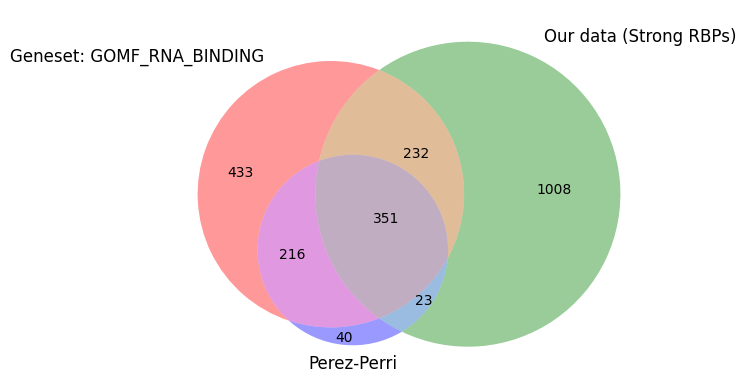

In [105]:
matplotlib_venn.venn3(
    (
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['goterm_set']
            )
        ].index),
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['strong_set']
            )
        ].index),
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['perezperri_hit']
            )
        ].index),
    ),
    set_labels=['Geneset: %s' % gs_name, "Our data (Strong RBPs)", "Perez-Perri"]
)

fig = plt.gcf()
fig.savefig("pipeline_activation/figures/venn_RBP_overlap.geneset_%s-PerezPerri-ours.pdf" % gs_name);

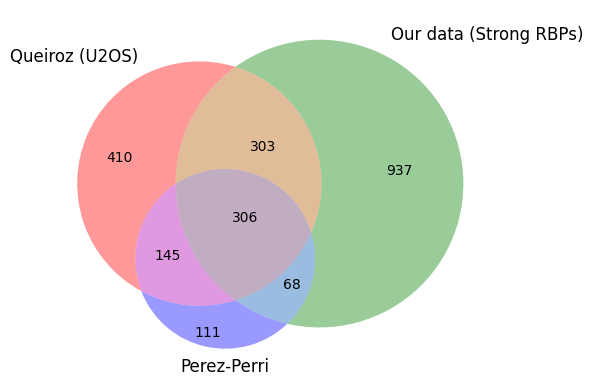

In [106]:
matplotlib_venn.venn3(
    (
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['queiroz_U2OS']
            )
        ].index),
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['strong_set']
            )
        ].index),
        set(output_tbl.loc[
            lambda df: (
                df['w_valid']
                & df['perezperri_hit']
            )
        ].index),
    ),
    set_labels=["Queiroz (U2OS)", "Our data (Strong RBPs)", "Perez-Perri"]
)

fig = plt.gcf()
fig.savefig("pipeline_activation/figures/venn_RBP_overlap.Queiroz-PerezPerri-ours.pdf");

---

In [107]:
candidate_novel_rbps = hdi_ds['Hd40'].isel(gene=(
    output_tbl['strong_set']
    & output_tbl['w_valid']
    & output_tbl['w_expr']
#     & ~(
#         output_tbl['goterm_set']
#         | output_tbl['queiroz_U2OS']
#         | output_tbl['perezperri_hit']
#     )
)[output_tbl['w_valid']]).sel(deriv_coef='RBPness').sel(hdi='lower').to_pandas().sort_values().index[::-1]

In [108]:
candidate_novel_rbps = E.isel(gene=(
    output_tbl['strong_set']
    & output_tbl['w_valid']
    & output_tbl['w_expr']
    & ~(
        output_tbl['goterm_set']
        | output_tbl['queiroz_U2OS']
        | output_tbl['perezperri_hit']
    )
)[output_tbl['w_valid']]).sel(coef='RBPness').to_pandas().sort_values().index[::-1]

In [109]:
hgnc_metadata.loc[candidate_novel_rbps].head(30)[['symbols', 'names']]

,symbols,names
gene,,
HGNC:4739,H2AX,H2A.X variant histone
HGNC:6621,LIPE,"lipase E, hormone sensitive type"
HGNC:11003,SLC29A1,solute carrier family 29 member 1 (Augustine b...
HGNC:32235,RBIS,ribosomal biogenesis factor
HGNC:9679,PTPRQ,protein tyrosine phosphatase receptor type Q
HGNC:2545,CTSS,cathepsin S
HGNC:3239,EGR2,early growth response 2
HGNC:11326,SSR4,signal sequence receptor subunit 4
HGNC:20566,SV2A,synaptic vesicle glycoprotein 2A


---

---

---